In [ ]:
pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.3 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline

from mne import Epochs, pick_types
from mne.channels import make_standard_montage
from mne.datasets import eegbci
from mne.decoding import CSP
from mne.io import concatenate_raws, read_raw_edf

print(__doc__)

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)
raw.annotations.rename(dict(T1="hands", T2="feet"))
raw.set_eeg_reference(projection=True)

# Apply band-pass filter
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    event_id=["hands", "feet"],
    tmin=tmin,
    tmax=tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Using default location ~/mne_data for EEGBCI...
Creating ~/mne_data


Do you want to set the path:
    /root/mne_data
as the default EEGBCI dataset path in the mne-python config [y]/n? y
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Download complete in 23s (7.4 MB)
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referen

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Used Annotations descriptions: ['T0', 'feet', 'hands']
Ignoring annotation durations and creating fixed-duration epochs around annotation onsets.
Not setting metadata
45 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


In [ ]:
labels

array([0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0])

Computing rank from data with rank=None
    Using tolerance 7.2e-05 (2.2e-16 eps * 64 dim * 5e+09  max singular value)
    Estimated rank (data): 63
    data: rank 63 computed from 64 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 64 dim * 4.9e+09  max singular value)
    Estimated rank (data): 63
    data: rank 63 computed from 64 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-05 (2.2e-16 eps * 64 dim * 5.1e+09  max singular value)
    Estimated rank (data): 63
    data: rank 63 computed 

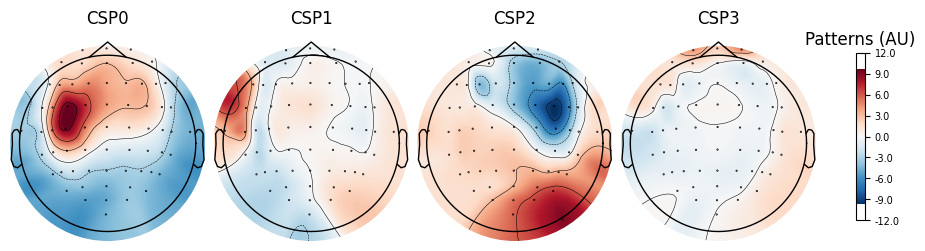

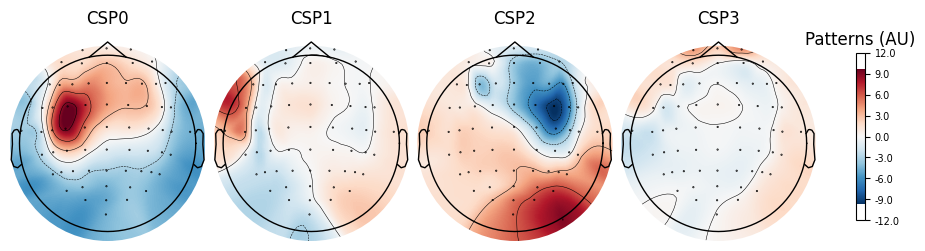

In [ ]:
# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1.0 - class_balance)
print(f"Classification accuracy: {np.mean(scores)} / Chance level: {class_balance}")

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

In [ ]:
epochs_data.shape

(45, 64, 801)

In [ ]:
epochs_data_train.shape

(45, 64, 161)

Computing rank from data with rank=None
    Using tolerance 7.2e-05 (2.2e-16 eps * 64 dim * 5e+09  max singular value)
    Estimated rank (data): 63
    data: rank 63 computed from 64 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.9e-05 (2.2e-16 eps * 64 dim * 4.9e+09  max singular value)
    Estimated rank (data): 63
    data: rank 63 computed from 64 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 64 -> 63
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 7.2e-05 (2.2e-16 eps * 64 dim * 5.1e+09  max singular value)
    Estimated rank (data): 63
    data: rank 63 computed 

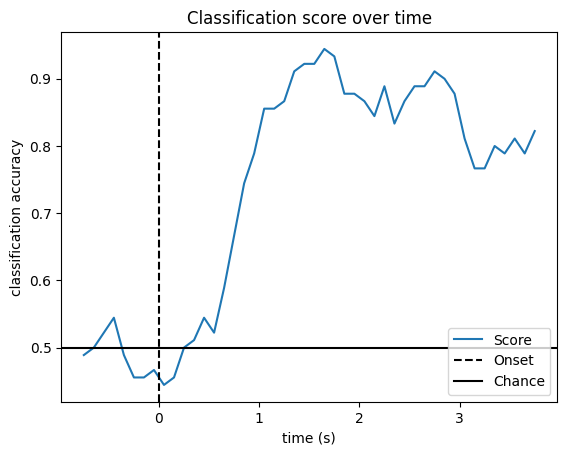

In [ ]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

print(__doc__)
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw_files = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = concatenate_raws(raw_files)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

# Apply band-pass filter
raw.filter(7., 30.)


Automatically created module for IPython interactive environment
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /root/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Measurement date,"August 12, 2009 16:15:00 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,64 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,160.00 Hz
Highpass,7.00 Hz
Lowpass,30.00 Hz


In [ ]:
from mne import events_from_annotations

# Convert annotations to events
events, _ = events_from_annotations(raw)
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
labels = epochs.events[:, -1] - 2

Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped


In [ ]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import ShuffleSplit  # or from sklearn.model_selection import train_test_split


# Assemble a classifier
lda = LDA()
csp = CSP(n_components=4, reg=None, log=True)

# Define a monte-carlo cross-validation generator (reduce variance):
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)


scores = []
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()


from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score  # Import cross_val_score from the correct module

clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=1)


# Printing the results
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (np.mean(scores),
                                                          class_balance))

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)

Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.


<ipython-input-66-b605eb40d621>:14: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data = epochs.get_data()
<ipython-input-66-b605eb40d621>:15: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs_data_train = epochs_train.get_data()


Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 64 dim * 9.8e+09  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00015 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank f

array([[-0.71861957, -0.98694322, -0.43511297, -0.89569724],
       [-1.4385357 , -1.1427975 , -0.97252324, -0.79149942],
       [-0.91601769, -1.0549246 , -1.14583143,  0.28226354],
       [-0.23785623, -1.18681831, -0.60742704, -1.13551579],
       [-1.46614779, -1.13194862, -1.16651377, -0.19853184],
       [-0.37499731, -1.04210972, -0.39524411, -1.09233129],
       [-0.21379868, -1.29319979, -0.50701736, -1.22250873],
       [-1.14666209, -1.12174813, -0.97139026, -0.8061797 ],
       [-0.9134896 , -1.28003401, -1.18964875,  0.7292505 ],
       [-0.34132284, -1.09075115, -0.45269748, -1.27628907],
       [-0.40794964, -0.83035715, -0.44963933, -1.09171582],
       [-1.35816092, -1.44203629, -0.79808688, -0.99030135],
       [-0.96317783, -0.9290915 , -1.20827494, -0.62336046],
       [-0.65427261, -1.26423805, -0.40165955, -1.2780047 ],
       [ 0.16929897, -0.85410672, -0.17470504, -0.86783015],
       [-1.16364594, -0.92397987, -1.45891392, -0.91523592],
       [-0.3194943 , -0.

In [ ]:
evoked = epochs.average()
evoked.data = csp.patterns_.T


In [ ]:

evoked.times = np.arange(evoked.data.shape[0])

layout = read_layout('EEG1005')
evoked.plot_topomap(times=[0, 1, 2, 3, 4, 5], ch_type='eeg', layout=layout,
                    scale_time=1, time_format='%i', scale=1,
                    unit='Patterns (AU)', size=1.5)

Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 64 dim * 9.8e+09  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIR

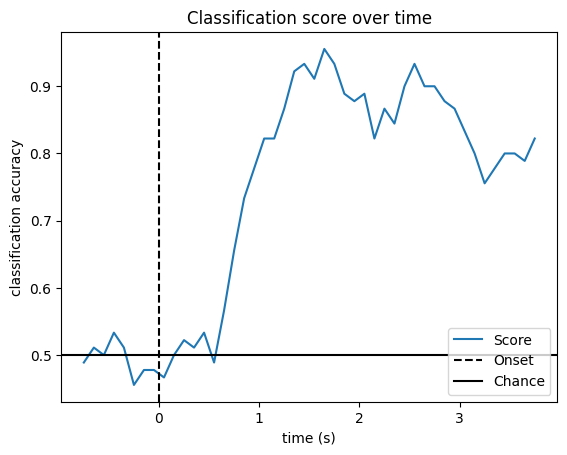

In [ ]:
sfreq = raw.info['sfreq']
w_length = int(sfreq * 0.5)   # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv.split(labels):
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n:(n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label='Score')
plt.axvline(0, linestyle='--', color='k', label='Onset')
plt.axhline(0.5, linestyle='-', color='k', label='Chance')
plt.xlabel('time (s)')
plt.ylabel('classification accuracy')
plt.title('Classification score over time')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from mne import Epochs, pick_types, find_events
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models

print(__doc__)
tmin, tmax = -1., 4.
event_id = dict(hands=2, feet=3)
subject = 1
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw_files = [read_raw_edf(f, preload=True) for f in raw_fnames]
raw = concatenate_raws(raw_files)

# strip channel names of "." characters
raw.rename_channels(lambda x: x.strip('.'))

# Apply band-pass filter
raw.filter(7., 30.)
from mne import events_from_annotations

# Convert annotations to events
events, _ = events_from_annotations(raw)
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                   exclude='bads')
epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                baseline=None, preload=True)

ModuleNotFoundError: No module named 'mne'

In [ ]:
epochs_train = epochs.copy().crop(tmin=1., tmax=2.)
epochs_test = epochs.copy().crop(tmin=2., tmax=3.)  # Adjust time window for test data
labels_train = epochs_train.events[:, -1] - 2
labels_test = epochs_test.events[:, -1] - 2

In [ ]:
labels_train


NameError: name 'labels_train' is not defined

In [ ]:

# Data normalization
X_train = epochs_train.get_data()
X_test = epochs_test.get_data()
mean, std = X_train.mean(), X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Data augmentation
def augment_data(X):
    return np.flip(X, axis=-1)  # Horizontal flip

X_train_augmented = augment_data(X_train)
X_train = np.concatenate((X_train, X_train_augmented), axis=0)
labels_train = np.concatenate((labels_train, labels_train), axis=0)

<ipython-input-38-3bb70ae2c0be>:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_train = epochs_train.get_data()
<ipython-input-38-3bb70ae2c0be>:3: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X_test = epochs_test.get_data()


In [ ]:
labels_train.shape

(90,)

In [ ]:
import numpy as np

# Assuming X_train and X_test are your input data arrays
X_train = X_train.reshape(-1, 64, 161, 1)  # Reshape for one channel
X_test = X_test.reshape(-1, 64, 161, 1)
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1:])),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
X_train.shape

(45, 64, 161)

In [ ]:
X_test.shape

(45, 64, 161)

Epoch 1/10
3/3 [==============================] - 10s 1s/step - loss: 1.4458 - accuracy: 0.4861 - val_loss: 0.7555 - val_accuracy: 0.4444
Epoch 2/10
3/3 [==============================] - 4s 1s/step - loss: 0.6839 - accuracy: 0.4722 - val_loss: 0.6892 - val_accuracy: 0.5556
Epoch 3/10
3/3 [==============================] - 3s 919ms/step - loss: 0.6631 - accuracy: 0.5972 - val_loss: 0.6859 - val_accuracy: 0.5556
Epoch 4/10
3/3 [==============================] - 3s 931ms/step - loss: 0.6298 - accuracy: 0.5833 - val_loss: 0.6876 - val_accuracy: 0.5556
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 0.5779 - accuracy: 0.6389 - val_loss: 0.6991 - val_accuracy: 0.4444
Epoch 6/10
3/3 [==============================] - 4s 1s/step - loss: 0.5114 - accuracy: 0.8333 - val_loss: 0.7023 - val_accuracy: 0.5556
Epoch 7/10
3/3 [==============================] - 3s 895ms/step - loss: 0.4258 - accuracy: 0.9028 - val_loss: 0.8049 - val_accuracy: 0.3889
Epoch 8/10
3/3 [===============

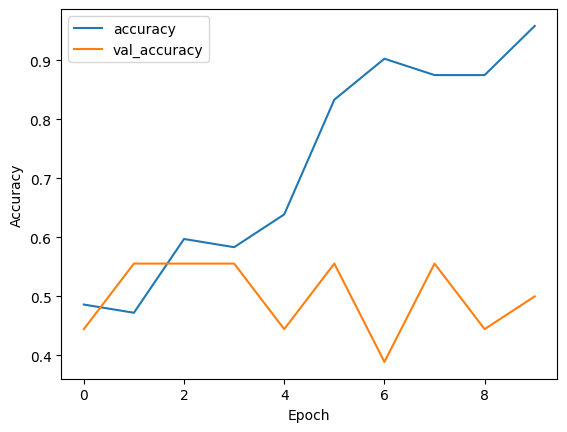

2/2 [==============================] - 0s 47ms/step


In [ ]:



# Define CNN architecture

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, labels_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, labels_test)
loss1, accuracy1 = model.evaluate(X_train, labels_train)
print("Test Accuracy:", accuracy)
print("Train Accuracy:", accuracy1)
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc = model.evaluate(X_test, labels_test)

# Predict labels for the test data
y_pred = model.predict(X_test)

# Compute classification accuracy over time



In [ ]:
pip install torch torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
from spektral.layers import GCNConv


In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-geometric


In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

In [ ]:
X_train.shape, labels_train.shape

((90, 64, 161), (90,))

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv

class GCNNModel(nn.Module):
    def __init__(self):
        super(GCNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels=161, out_channels=64)  # Adjust in_channels based on input feature dimensionality
        self.conv2 = GCNConv(in_channels=64, out_channels=2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = torch.mean(x, dim=1)  # Global pooling to aggregate node features
        return x

# Convert input data to torch tensor
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
test_data =  Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
# Initialize model
model = GCNNModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
labels_train = torch.tensor(labels_train, dtype=torch.long)
# Training loop
num_epochs=10
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_data)
    # Convert labels_train to torch.long


# Compute loss
    loss = criterion(output, labels_train)

    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')
labels_test = torch.tensor(labels_test, dtype=torch.long)

# Evaluate the model
model.eval()
with torch.no_grad():
    test_output = model(test_data)
    test_loss = criterion(test_output, labels_test)
    ## Convert test_output to class labels
    predicted_labels = (test_output > 0.5).float()  # Binary classification thresholding
    predicted_labels = torch.argmax(predicted_labels, dim=1)  # Select class with highest probability

# Ensure both tensors have the same shape for comparison
    if predicted_labels.dim() > 1:  # If predicted_labels has more than 1 dimension
        predicted_labels = predicted_labels.squeeze()  # Remove extra dimensions if any

# Compute accuracy
test_accuracy = (predicted_labels == labels_test).float().mean()

print(f'Test Loss: {test_loss.item()}, Test Accuracy: {test_accuracy.item()}')

<ipython-input-28-faed7dfda28f>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
<ipython-input-28-faed7dfda28f>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data =  Data(x=torch.tensor(X_test, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
<ipython-input-28-faed7dfda28f>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(labels_train, dtype=torch.long)


Epoch [1/10], Loss: 0.5858403444290161
Epoch [2/10], Loss: 0.5230523347854614
Epoch [3/10], Loss: 0.4696338474750519
Epoch [4/10], Loss: 0.4307842254638672
Epoch [5/10], Loss: 0.39762312173843384
Epoch [6/10], Loss: 0.3767949342727661
Epoch [7/10], Loss: 0.3588370680809021
Epoch [8/10], Loss: 0.3438062369823456
Epoch [9/10], Loss: 0.3313193619251251
Epoch [10/10], Loss: 0.3211738169193268
Test Loss: 0.8891713619232178, Test Accuracy: 0.4444444477558136


<ipython-input-29-9df0b3ee33e1>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
<ipython-input-29-9df0b3ee33e1>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data = Data(x=torch.tensor(X_val, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
<ipython-input-29-9df0b3ee33e1>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val = torch.tensor(labels_val, dtype=torch.long)
<ipython-inp

Epoch [1/10], Train Loss: 0.6464746594429016, Train Accuracy: 0.5, Val Loss: 0.444979190826416, Val Accuracy: 0.6666666865348816
Epoch [2/10], Train Loss: 0.5792486667633057, Train Accuracy: 0.5, Val Loss: 0.4558112621307373, Val Accuracy: 0.6666666865348816
Epoch [3/10], Train Loss: 0.5327839255332947, Train Accuracy: 0.6000000238418579, Val Loss: 0.4671962559223175, Val Accuracy: 0.6666666865348816
Epoch [4/10], Train Loss: 0.495446115732193, Train Accuracy: 0.6000000238418579, Val Loss: 0.47885480523109436, Val Accuracy: 0.6666666865348816
Epoch [5/10], Train Loss: 0.46554651856422424, Train Accuracy: 0.6000000238418579, Val Loss: 0.48979440331459045, Val Accuracy: 0.6666666865348816
Epoch [6/10], Train Loss: 0.4431169629096985, Train Accuracy: 0.6000000238418579, Val Loss: 0.5014001727104187, Val Accuracy: 0.6666666865348816
Epoch [7/10], Train Loss: 0.42513513565063477, Train Accuracy: 0.6000000238418579, Val Loss: 0.5131819844245911, Val Accuracy: 0.6666666865348816
Epoch [8/10],

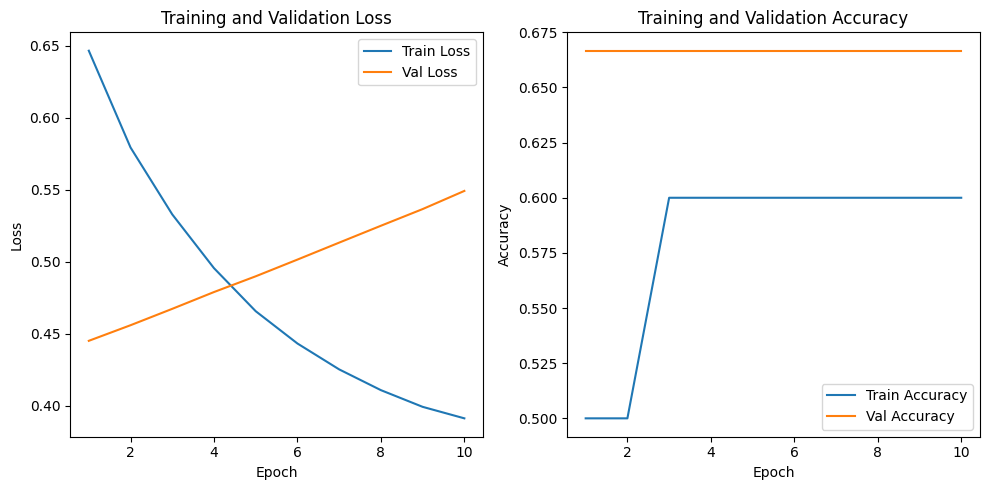

In [ ]:
X_train, X_val, labels_train, labels_val = train_test_split(X_train, labels_train, test_size=0.2, random_state=42)
num_nodes = torch.tensor(X_train, dtype=torch.long).size(1)  # Number of electrodes
edge_index = torch.tensor([(i, j) for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous()

class GCNNModel(nn.Module):
    def __init__(self):
        super(GCNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels=161, out_channels=64)  # Adjust in_channels based on input feature dimensionality
        self.conv2 = GCNConv(in_channels=64, out_channels=2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = torch.mean(x, dim=1)  # Global pooling to aggregate node features
        return x

# Convert input data to torch tensor
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
val_data = Data(x=torch.tensor(X_val, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))

# Initialize model
model = GCNNModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
labels_val = torch.tensor(labels_val, dtype=torch.long)
labels_train = torch.tensor(labels_train, dtype=torch.long)
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Train
    model.train()
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, labels_train)
    loss.backward()
    optimizer.step()

    # Compute training accuracy
    predicted_labels_train = torch.argmax(output, dim=1)
    train_accuracy = (predicted_labels_train == labels_train).float().mean()

    # Validate
    model.eval()
    with torch.no_grad():
        val_output = model(val_data)
        val_loss = criterion(val_output, labels_val)
        predicted_labels_val = torch.argmax(val_output, dim=1)
        val_accuracy = (predicted_labels_val == labels_val).float().mean()

    # Store loss and accuracy
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_accuracy.item())
    val_accuracies.append(val_accuracy.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item()}, Train Accuracy: {train_accuracy.item()}, Val Loss: {val_loss.item()}, Val Accuracy: {val_accuracy.item()}')

# Plot training history
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


<ipython-input-41-bd38a450fc35>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
<ipython-input-41-bd38a450fc35>:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_data = Data(x=torch.tensor(X_val, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
<ipython-input-41-bd38a450fc35>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val = torch.tensor(labels_val, dtype=torch.long)
<ipython-inp

Epoch [1/10], Train Loss: 0.6918233036994934, Train Accuracy: 0.5777778029441833, Val Loss: 0.6786999106407166, Val Accuracy: 0.6666666865348816
Epoch [2/10], Train Loss: 0.6655797362327576, Train Accuracy: 0.6000000238418579, Val Loss: 0.669693648815155, Val Accuracy: 0.6666666865348816
Epoch [3/10], Train Loss: 0.645833432674408, Train Accuracy: 0.7777777910232544, Val Loss: 0.6607134342193604, Val Accuracy: 0.5833333134651184
Epoch [4/10], Train Loss: 0.6286076903343201, Train Accuracy: 0.8222222328186035, Val Loss: 0.6538531184196472, Val Accuracy: 0.6666666865348816
Epoch [5/10], Train Loss: 0.6082872748374939, Train Accuracy: 0.8222222328186035, Val Loss: 0.6516749262809753, Val Accuracy: 0.5833333134651184
Epoch [6/10], Train Loss: 0.589863121509552, Train Accuracy: 0.7777777910232544, Val Loss: 0.6500576138496399, Val Accuracy: 0.5833333134651184
Epoch [7/10], Train Loss: 0.5726935267448425, Train Accuracy: 0.7555555701255798, Val Loss: 0.6507640480995178, Val Accuracy: 0.58333

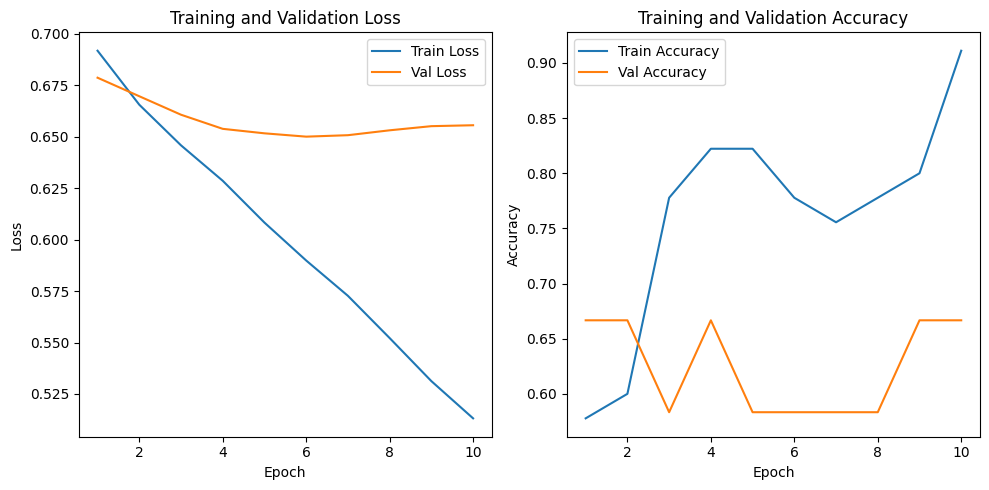

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, labels_train, labels_val = train_test_split(X_train, labels_train, test_size=0.2, random_state=42)

class GCNNModel(nn.Module):
    def __init__(self):
        super(GCNNModel, self).__init__()
        self.conv1 = GCNConv(in_channels=161, out_channels=128)
        self.conv2 = GCNConv(in_channels=128, out_channels=64)
        self.conv3 = GCNConv(in_channels=64, out_channels=32)
        self.conv4 = GCNConv(in_channels=32, out_channels=16)
        self.conv5 = GCNConv(in_channels=16, out_channels=2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)
        x = torch.relu(x)
        x = self.conv5(x, edge_index)
        x = torch.relu(x)
        x = torch.mean(x, dim=1)

        return x

# Convert input data to torch tensor
train_data = Data(x=torch.tensor(X_train, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))
val_data = Data(x=torch.tensor(X_val, dtype=torch.float), edge_index=torch.tensor(edge_index, dtype=torch.long))

# Initialize model
model = GCNNModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
labels_val = torch.tensor(labels_val, dtype=torch.long)
labels_train = torch.tensor(labels_train, dtype=torch.long)
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Train
    model.train()
    optimizer.zero_grad()
    output = model(train_data)
    loss = criterion(output, labels_train)
    loss.backward()
    optimizer.step()

    # Compute training accuracy
    predicted_labels_train = torch.argmax(output, dim=1)
    train_accuracy = (predicted_labels_train == labels_train).float().mean()

    # Validate
    model.eval()
    with torch.no_grad():
        val_output = model(val_data)
        val_loss = criterion(val_output, labels_val)
        predicted_labels_val = torch.argmax(val_output, dim=1)
        val_accuracy = (predicted_labels_val == labels_val).float().mean()

    # Store loss and accuracy
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_accuracy.item())
    val_accuracies.append(val_accuracy.item())

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss.item()}, Train Accuracy: {train_accuracy.item()}, Val Loss: {val_loss.item()}, Val Accuracy: {val_accuracy.item()}')

# Plot training history
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
